# Cotas para Exercício da Atividade Parlamentar dos Senadores (CEAPS)

Segundo o site da Câmara dos Deputados (https://www2.camara.leg.br/transparencia/acesso-a-informacao/copy_of_perguntas-frequentes/cota-para-o-exercicio-da-atividade-parlamentar), a Cota para o Exercício da Atividade Parlamentar – CEAP (antiga verba indenizatória) é uma cota única mensal destinada a custear os gastos dos deputados exclusivamente vinculados ao exercício da atividade parlamentar.

O Ato da Mesa nº 43 de 2009, que detalha as regras para o uso da CEAP, determina que só podem ser indenizadas despesas com:
* passagens aéreas;
* telefonia; 
* serviços postais; 
* manutenção de escritórios de apoio à atividade parlamentar; 
* assinatura de publicações; 
* fornecimento de alimentação ao parlamentar; 
* hospedagem;
* outras despesas com locomoção, contemplando locação ou fretamento de aeronaves, veículos automotores e embarcações, serviços de táxi, pedágio e estacionamento e passagens terrestres, marítimas ou fluviais; 
* combustíveis e lubrificantes; 
* serviços de segurança; 
* contratação de consultorias e trabalhos técnicos; 
* divulgação da atividade parlamentar, exceto nos 120 dias anteriores às eleições; 
* participação do parlamentar em cursos, palestras, seminários, simpósios, congressos ou eventos congêneres; 
* e a complementação do auxílio-moradia.

O valor máximo mensal da cota depende da unidade da federação que o deputado representa. Essa variação ocorre por causa das passagens aéreas e está relacionada ao valor do trecho entre Brasília e o Estado que o deputado representa.

Segundo Beatriz Freire, no site https://www.politize.com.br/cota-parlamentar/: 'Outro ponto é que o saldo da cota parlamentar (o valor por mês que não foi utilizado) acumula-se ao longo do exercício financeiro (no Brasil o exercício financeiro coincide com o ano civil, o que entendemos como ano). Mas atenção, os valores não acumulam de um exercício financeiro para o seguinte, ou seja, quando termina o ano, o parlamentar não pode utilizar o que sobrou.'

## Problemas de Pesquisa

1) Quem são os TOP 5 maiores gastos de cada ano?

        1.1) Podemos detalhar com o que foram realizados esses gastos?

2) Quais foram os TOP 5 maiores gastos por tipos de despesa por ano?

3) Qual será a melhor forma para analisar se um gasto pode ser categorizado como suspeito?

        3.1) Podemos criar um filtro para gastos suspeitos?

## Bibliotecas

In [1]:
import pandas as pd
import warnings
from IPython.display import display, Markdown, HTML
import locale
from babel.numbers import format_currency
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
warnings.filterwarnings('ignore')

## Funções
Nesta sessão ficarão as funções criadas para este projeto.

In [83]:
# Função para concatenar dataframes
def concat(dataframes_list):
    df_concat = pd.concat(dataframes_list, ignore_index=True)
    return df_concat

# Função para selecionar o ano
def select_year(df, year):
    year_df = df[df['ANO'] == year]
    return year_df

# Função para criar DF contagem de solicitações por senador
def count(df, ano):
    contagem_ano = df.query("ANO == @ano")
    df_ano = contagem_ano.sort_values("CONTAGEM", ascending=False)
    return df_ano
    
# Função para criar DF Valor Total por senador
def value_sum(df):
    df_agrupado = df.groupby('SENADOR')['VALOR_REEMBOLSADO'].sum()
    df_agrupado = df_agrupado.to_frame()
    df_agrupado = df_agrupado.rename(columns={'SENADOR': 'SENADOR', 'VALOR_REEMBOLSADO': 'VALOR_REEMBOLSADO'})
    df_agrupado = df_agrupado.sort_values("VALOR_REEMBOLSADO", ascending=False)
    return df_agrupado

# Função para criar DF Valor Total por Tipo de Despesa
def value_type(df, year):
    df_agrupado = df.groupby('TIPO_DESPESA')['VALOR_REEMBOLSADO'].sum()
    df_agrupado = df_agrupado.to_frame()
    df_agrupado = df_agrupado.rename(columns={'TIPO_DESPESA': 'TIPO_DESPESA','VALOR_REEMBOLSADO': f'VALOR_TOTAL_{year}'})
    df_agrupado = df_agrupado.sort_values(f"VALOR_TOTAL_{year}", ascending=False)
    return df_agrupado

# Função para mostrar o valor total por ano
def total_value(df, year):
    locale.setlocale(locale.LC_ALL, 'pt_BR.UTF-8')
    soma_total = df[f'VALOR_TOTAL_{year}'].sum()
    valor_formatado = format_currency(soma_total, 'BRL', format='#,##0.00', locale='pt_BR')
    print(f"Soma total dos valores do ano de {year}: R$", valor_formatado)    

# Função para realizar a porcentagem de nulos por coluna
def nulls(df):
    nulls_percent = df.isnull().mean() * 100
    return nulls_percent

# Função para tratar valores da coluna VALOR_REEMBOLSADO e substituir a vírgula por ponto
def treat_value(df):
    df.loc[:, 'VALOR_REEMBOLSADO'] = df.loc[:, 'VALOR_REEMBOLSADO'].str.replace(',', '.').astype(float)
    
# Função para centralizar o dataframe
def center_df(df):
    df = df.style.set_table_attributes('style="margin-left: auto; margin-right: auto;"')
    return HTML(df.render())
    
# Função para inserir título
def title(title, size):
    return Markdown(f'<h1 style="font-size:{size}px; text-align:center;">{title}</h1>')

# FUnção para alterar tipo coluna para data
def todate(df):
    df_concat['DATA'] = pd.to_datetime(df_concat['DATA'], format='%d/%m/%Y', errors='coerce')
    return df['DATA']

# Função remover colunas
def drop(df, columns_list):
    df = df.drop(columns=columns_list)
    return df

## Importação de Dados

Os dados que serão utilizados são referentes aos anos de 2018 a 2022, disponíveis no site:
https://www12.senado.leg.br/transparencia/dados-abertos-transparencia/dados-abertos-ceaps

In [3]:
# Importando dados
data_2018 = pd.read_csv('data/despesa_ceaps_2018.csv', encoding='latin-1', sep=';', skiprows=[0])
data_2019 = pd.read_csv('data/despesa_ceaps_2019.csv', encoding='latin-1', sep=';', skiprows=[0])
data_2020 = pd.read_csv('data/despesa_ceaps_2020.csv', encoding='latin-1', sep=';', skiprows=[0])
data_2021 = pd.read_csv('data/despesa_ceaps_2021.csv', encoding='latin-1', sep=';', skiprows=[0])
data_2022 = pd.read_csv('data/despesa_ceaps_2022.csv', encoding='latin-1', sep=';', skiprows=[0])

## Concatenação das Tabelas 2018 - 2022
Para análise exploratória e comparação dos dados iremos agrupá-los em um único arquivo. 
Em alguns momentos ainda os dados separados por anos ainda serão utilizados.

In [4]:
df_concat = concat([data_2018, data_2019, data_2020, data_2021, data_2022] )
""" Comentários:
    Corrigir os valores da coluna VALOR_REEMBOLSADO (trocar , por .)
    Todos os dados que não for possível de realizar sua categorização serão excluídos desta análise (DOCUMENTO, COD_DOCUMENTO)"""
df_concat

,ANO,MES,SENADOR,TIPO_DESPESA,CNPJ_CPF,FORNECEDOR,DOCUMENTO,DATA,DETALHAMENTO,VALOR_REEMBOLSADO,COD_DOCUMENTO
0,2018,1,ACIR GURGACZ,"Aluguel de imóveis para escritório político, c...",004.948.028-63,GILBERTO PISELO DO NASCIMENTO,NaN,02/01/2018,Despesa com pagamento de aluguel de imóvel par...,6000,2088462
1,2018,1,ACIR GURGACZ,"Passagens aéreas, aquáticas e terrestres nacio...",63.764.211/0001-10,TRANSCONTINENTAL AGÊNCIA DE VIAGENS LTDA,M2CJMM,02/01/2018,"Companhia Aérea: AVIANCA, Localizador: M2CJMM....","274,99",2088476
2,2018,1,ACIR GURGACZ,"Passagens aéreas, aquáticas e terrestres nacio...",63.764.211/0001-10,TRANSCONTINENTAL AGÊNCIA DE VIAGENS LTDA,SFEXYF,02/01/2018,"Companhia Aérea: LATAM, Localizador: SFEXYF. P...","1094,29",2088528
3,2018,1,ACIR GURGACZ,"Passagens aéreas, aquáticas e terrestres nacio...",63.764.211/0001-10,TRANSCONTINENTAL AGÊNCIA DE VIAGENS LTDA,V64HTR,24/01/2018,"Companhia Aérea: AZUL, Localizador: V64HTR. Pa...","1553,99",2088475
4,2018,2,ACIR GURGACZ,"Aluguel de imóveis para escritório político, c...",004.948.028-63,GILBERTO PISELO DO NASCIMENTO,002/18,01/02/2018,Despesa com pagamento de aluguel de imóvel par...,6000,2088477
...,...,...,...,...,...,...,...,...,...,...,...
93756,2022,12,ZEQUINHA MARINHO,"Passagens aéreas, aquáticas e terrestres nacio...",22.052.777/0001-32,Exceller Tour,WIXHAI,06/12/2022,"Companhia Aérea: LATAM, Localizador: WIXHAI. P...","2893,04",2191398
93757,2022,12,ZEQUINHA MARINHO,"Passagens aéreas, aquáticas e terrestres nacio...",22.052.777/0001-32,Exceller Tour,WITOLM,09/12/2022,"Companhia Aérea: GOL, Localizador: WITOLM. Pas...","1180,19",2192272
93758,2022,12,ZEQUINHA MARINHO,"Passagens aéreas, aquáticas e terrestres nacio...",22.052.777/0001-32,Exceller Tour,THPKVQ,20/12/2022,"Companhia Aérea: TAM, Localizador: THPKVQ. Pas...","2671,9",2192274
93759,2022,12,ZEQUINHA MARINHO,"Passagens aéreas, aquáticas e terrestres nacio...",22.052.777/0001-32,Exceller Tour,QNN9HX,21/12/2022,"Companhia Aérea: AZUL, Localizador: QNN9HX. Pa...","1334,31",2192244


## Análise Exploratória

In [5]:
# Tipos das colunas

"""Comentários:
    Arrumar tipo de valor reembolsado, object para float
    Arrumar tipo de data, object para date
"""

df_types = df_concat.dtypes.reset_index()
df_types.rename(columns={'index': 'Coluna', 0: 'Tipo'}, inplace=True)
display(title('Tipos das Colunas', 20))
center_df(df_types)

<h1 style="font-size:20px; text-align:center;">Tipos das Colunas</h1>

,Coluna,Tipo
0,ANO,int64
1,MES,int64
2,SENADOR,object
3,TIPO_DESPESA,object
4,CNPJ_CPF,object
5,FORNECEDOR,object
6,DOCUMENTO,object
7,DATA,object
8,DETALHAMENTO,object
9,VALOR_REEMBOLSADO,object


## Criação do Dicionário de Dados


In [6]:
# Dicionário de Dados
titulo = 'Dicionário de Dados'
tamanho_fonte = 24

dataframe = {'Colunas': ['ANO', 
                         'MES', 
                         'SENADOR', 
                         'TIPO_DESPESA', 
                         'CNPJ_CPF', 
                         'FORNECEDOR',
                         'DATA', 
                         'DETALHAMENTO', 
                         'VALOR_REEMBOLSADO'],
            'Descrição': ['Ano da Despesa', 
                          'Mês da Despesa', 
                          'Nome do Senador que realizou a Despesa',
                          'Tipificação da Despesa',
                          'CNPJ ou CPF do executor da Despesa',
                          'Nome do Fornecedor da Despesa',
                          'Data de Apresentação da Despesa',
                          'Detalhamento da Despesa',
                          'Valor a ser reembolsado com a Despesa']}

dic = pd.DataFrame(dataframe)

dic_estilizado = dic.style.set_table_attributes('style="margin-left: auto; margin-right: auto;"')
display(Markdown(f'<h1 style="font-size:{tamanho_fonte}px; text-align:center;">{titulo}</h1>'))
display(HTML(dic_estilizado.render()))


<h1 style="font-size:24px; text-align:center;">Dicionário de Dados</h1>

,Colunas,Descrição
0,ANO,Ano da Despesa
1,MES,Mês da Despesa
2,SENADOR,Nome do Senador que realizou a Despesa
3,TIPO_DESPESA,Tipificação da Despesa
4,CNPJ_CPF,CNPJ ou CPF do executor da Despesa
5,FORNECEDOR,Nome do Fornecedor da Despesa
6,DATA,Data de Apresentação da Despesa
7,DETALHAMENTO,Detalhamento da Despesa
8,VALOR_REEMBOLSADO,Valor a ser reembolsado com a Despesa


In [7]:
df_concat.columns

Index(['ANO', 'MES', 'SENADOR', 'TIPO_DESPESA', 'CNPJ_CPF', 'FORNECEDOR',
       'DOCUMENTO', 'DATA', 'DETALHAMENTO', 'VALOR_REEMBOLSADO',
       'COD_DOCUMENTO'],
      dtype='object')

### Valores Nulos

In [47]:
null_2018 = nulls(data_2018).reset_index()
null_2018.rename(columns={'index': 'Coluna', 0: 'Porcentagem_Nulos'}, inplace=True)
display(title('Porcentagem de Valores Nulos 2018', 24))
center_df(null_2018)

<h1 style="font-size:24px; text-align:center;">Porcentagem de Valores Nulos 2018</h1>

,Coluna,Porcentagem_Nulos
0,ANO,0.000000
1,MES,0.000000
2,SENADOR,0.000000
3,TIPO_DESPESA,0.000000
4,CNPJ_CPF,0.000000
5,FORNECEDOR,0.000000
6,DATA,0.000000
7,DETALHAMENTO,22.905439
8,VALOR_REEMBOLSADO,0.000000


In [46]:
null_2019 = nulls(data_2019).reset_index()
null_2019.rename(columns={'index': 'Coluna', 0: 'Porcentagem_Nulos'}, inplace=True)
display(title('Porcentagem de Valores Nulos 2019', 24))
center_df(null_2019)

<h1 style="font-size:24px; text-align:center;">Porcentagem de Valores Nulos 2019</h1>

,Coluna,Porcentagem_Nulos
0,ANO,0.000000
1,MES,0.000000
2,SENADOR,0.000000
3,TIPO_DESPESA,0.000000
4,CNPJ_CPF,0.000000
5,FORNECEDOR,0.000000
6,DATA,0.000000
7,DETALHAMENTO,39.484145
8,VALOR_REEMBOLSADO,0.000000


In [48]:
null_2020 = nulls(data_2020).reset_index()
null_2020.rename(columns={'index': 'Coluna', 0: 'Porcentagem_Nulos'}, inplace=True)
display(title('Porcentagem de Valores Nulos 2020', 24))
center_df(null_2020)

<h1 style="font-size:24px; text-align:center;">Porcentagem de Valores Nulos 2020</h1>

,Coluna,Porcentagem_Nulos
0,ANO,0.000000
1,MES,0.000000
2,SENADOR,0.000000
3,TIPO_DESPESA,0.000000
4,CNPJ_CPF,0.000000
5,FORNECEDOR,0.000000
6,DATA,0.000000
7,DETALHAMENTO,48.701207
8,VALOR_REEMBOLSADO,0.000000


In [49]:
null_2021 = nulls(data_2021).reset_index()
null_2021.rename(columns={'index': 'Coluna', 0: 'Porcentagem_Nulos'}, inplace=True)
display(title('Porcentagem de Valores Nulos 2021', 24))
center_df(null_2021)

<h1 style="font-size:24px; text-align:center;">Porcentagem de Valores Nulos 2021</h1>

,Coluna,Porcentagem_Nulos
0,ANO,0.000000
1,MES,0.000000
2,SENADOR,0.000000
3,TIPO_DESPESA,0.000000
4,CNPJ_CPF,0.000000
5,FORNECEDOR,0.000000
6,DATA,0.000000
7,DETALHAMENTO,45.320021
8,VALOR_REEMBOLSADO,0.000000


In [50]:
null_2022 = nulls(data_2022).reset_index()
null_2022.rename(columns={'index': 'Coluna', 0: 'Porcentagem_Nulos'}, inplace=True)
display(title('Porcentagem de Valores Nulos 2022', 24))
center_df(null_2022)

<h1 style="font-size:24px; text-align:center;">Porcentagem de Valores Nulos 2022</h1>

,Coluna,Porcentagem_Nulos
0,ANO,0.000000
1,MES,0.000000
2,SENADOR,0.000000
3,TIPO_DESPESA,0.000000
4,CNPJ_CPF,0.000000
5,FORNECEDOR,0.000000
6,DATA,0.000000
7,DETALHAMENTO,45.836823
8,VALOR_REEMBOLSADO,0.000000


In [51]:
""" Comentários:
    Atentar para os valores nulos da coluna DETALHAMENTO que tiveram um aumento importante na virada de governo
    Quem são os senadores que mais possuem nulos na coluna DETALHAMENTO?"""
null_concat = nulls(df_concat).reset_index()
null_concat.rename(columns={'index': 'Coluna', 0: 'Porcentagem_Nulos'}, inplace=True)

display(title('Porcentagem de Valores Nulos 2018-2022', 24))
center_df(null_concat)

<h1 style="font-size:24px; text-align:center;">Porcentagem de Valores Nulos 2018-2022</h1>

,Coluna,Porcentagem_Nulos
0,ANO,0.000000
1,MES,0.000000
2,SENADOR,0.000000
3,TIPO_DESPESA,0.000000
4,CNPJ_CPF,0.000000
5,FORNECEDOR,0.000000
6,DATA,0.005333
7,DETALHAMENTO,38.718657
8,VALOR_REEMBOLSADO,0.000000


### Histograma das Variáveis Categóricas

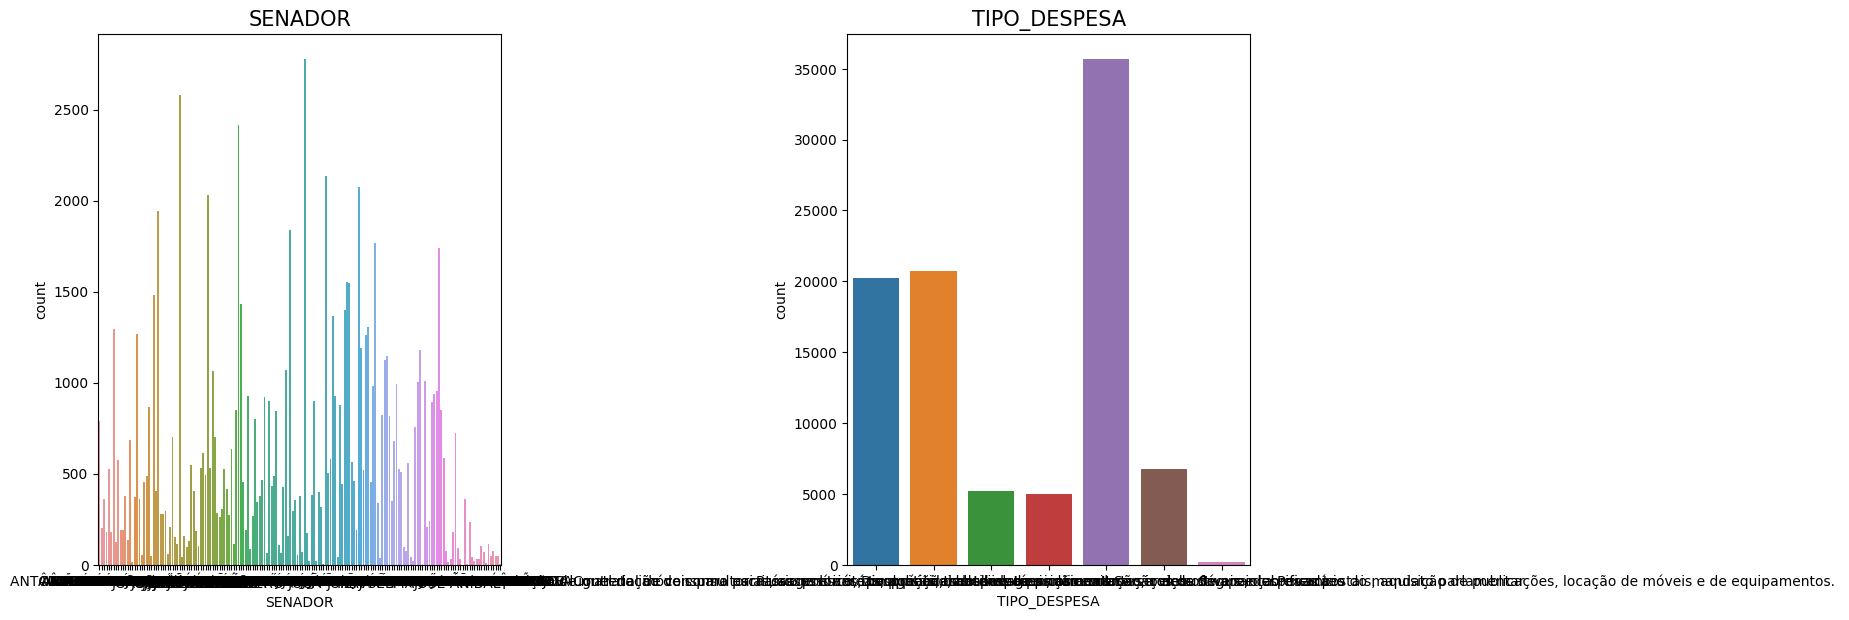

In [15]:
#Criação histogramas
plt.figure(figsize=(18, 30))
#Seleção dos valores categóricos
column_list = list(df_concat.columns.values)[2:4]

A = 0

for i in column_list:
    A += 1
    plt.subplot(5, 2, A)
    ax = sns.countplot(data = df_concat.fillna('NaN'), x = i)
    plt.title(i, fontsize = 15)
    
plt.tight_layout(h_pad = 2)


### Boxplot Variáveis Numéricas

In [16]:
"""# Configurar os subplots
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(12, 4))

# Utiliza o loop para criar um boxplot para cada ano em um subplot
for i, ano in enumerate(range(2018, 2023)):
    dados_ano = df_concat[df_concat['ANO'] == ano]
    sns.boxplot(data=dados_ano, x='ANO', y='VALOR_REEMBOLSADO', ax=axes[i])
    axes[i].set_title(f'Ano {ano}', fontsize=12)
    axes[i].set_xlabel('Ano', fontsize=10)
    axes[i].set_ylabel('Valor Reembolsado', fontsize=10)

plt.tight_layout()
"""

"# Configurar os subplots\nfig, axes = plt.subplots(nrows=1, ncols=5, figsize=(12, 4))\n\n# Utiliza o loop para criar um boxplot para cada ano em um subplot\nfor i, ano in enumerate(range(2018, 2023)):\n    dados_ano = df_concat[df_concat['ANO'] == ano]\n    sns.boxplot(data=dados_ano, x='ANO', y='VALOR_REEMBOLSADO', ax=axes[i])\n    axes[i].set_title(f'Ano {ano}', fontsize=12)\n    axes[i].set_xlabel('Ano', fontsize=10)\n    axes[i].set_ylabel('Valor Reembolsado', fontsize=10)\n\nplt.tight_layout()\n"

## Tratamento dos Dados

In [17]:
# Retirando as colunas que não serão utilizadas
columns_list = ['DOCUMENTO', 'COD_DOCUMENTO']
df_concat = drop(df_concat, columns_list)
data_2018 = drop(data_2018, columns_list)
data_2019 = drop(data_2019, columns_list)
data_2020 = drop(data_2020, columns_list)
data_2021 = drop(data_2021, columns_list)
data_2022 = drop(data_2022, columns_list)

In [18]:
# Tratamento dos valores da coluna VALOR_REEMBOLSADO (retirando , e inserindo .) e do tipo da coluna (object to float)
treat_value(df_concat)
treat_value(data_2018)
treat_value(data_2019)
treat_value(data_2020)
treat_value(data_2021)
treat_value(data_2022)

In [19]:
# Tratamento do tipo da coluna DATA
todate(df_concat)
todate(data_2018)
todate(data_2019)
todate(data_2020)
todate(data_2021)
todate(data_2022)

data_2022.dtypes

ANO                    int64
MES                    int64
SENADOR               object
TIPO_DESPESA          object
CNPJ_CPF              object
FORNECEDOR            object
DATA                  object
DETALHAMENTO          object
VALOR_REEMBOLSADO    float64
dtype: object

## Levantamento dos Dados

### Criação de Dataframes

In [58]:
df_type_2018 = data_2019[['TIPO_DESPESA', 'VALOR_REEMBOLSADO']]
df_type_2019 = data_2019[['TIPO_DESPESA', 'VALOR_REEMBOLSADO']]
df_type_2020 = data_2020[['TIPO_DESPESA', 'VALOR_REEMBOLSADO']]
df_type_2021 = data_2021[['TIPO_DESPESA', 'VALOR_REEMBOLSADO']]
df_type_2022 = data_2022[['TIPO_DESPESA', 'VALOR_REEMBOLSADO']]

## 1) Quem são os TOP 5 maiores gastos de cada ano? 

### Podemos detalhar com o que foram realizados esses gastos?

In [72]:
top_5_2018 = data_2018.sort_values(by='VALOR_REEMBOLSADO', ascending=False)
display(title('TOP 5 Maiores Gastos 2018', 24))
top_5_2018[['TIPO_DESPESA', 'DETALHAMENTO', 'VALOR_REEMBOLSADO']].head(5)

<h1 style="font-size:24px; text-align:center;">TOP 5 Maiores Gastos 2018</h1>

,TIPO_DESPESA,DETALHAMENTO,VALOR_REEMBOLSADO
21225,Divulgação da atividade parlamentar,NaN,103900.0
21488,"Contratação de consultorias, assessorias, pesq...",NaN,102000.0
21491,"Contratação de consultorias, assessorias, pesq...",NaN,102000.0
22666,"Contratação de consultorias, assessorias, pesq...",TRABALHOS TÉCNICOS DE APOIO AO EXERCICIO DO MA...,100000.0
5573,Divulgação da atividade parlamentar,NaN,66000.0


In [73]:
top_5_2019 = data_2019.sort_values(by='VALOR_REEMBOLSADO', ascending=False)
display(title('TOP 5 Maiores Gastos 2019', 24))
top_5_2019[['TIPO_DESPESA', 'DETALHAMENTO', 'VALOR_REEMBOLSADO']].head(5)

<h1 style="font-size:24px; text-align:center;">TOP 5 Maiores Gastos 2019</h1>

,TIPO_DESPESA,DETALHAMENTO,VALOR_REEMBOLSADO
17761,"Contratação de consultorias, assessorias, pesq...",NaN,79200.0
3628,"Locomoção, hospedagem, alimentação, combustíve...",NaN,66730.0
690,Divulgação da atividade parlamentar,Divulgação da Atividade Parlamentar.,65000.0
17860,"Contratação de consultorias, assessorias, pesq...",NaN,57000.0
17878,"Contratação de consultorias, assessorias, pesq...",NaN,57000.0


In [74]:
top_5_2020 = data_2020.sort_values(by='VALOR_REEMBOLSADO', ascending=False)
display(title('TOP 5 Maiores Gastos 2020', 24))
top_5_2020[['TIPO_DESPESA', 'DETALHAMENTO', 'VALOR_REEMBOLSADO']].head(5)

<h1 style="font-size:24px; text-align:center;">TOP 5 Maiores Gastos 2020</h1>

,TIPO_DESPESA,DETALHAMENTO,VALOR_REEMBOLSADO
13262,"Contratação de consultorias, assessorias, pesq...",Despesa com serviço de consultoria e assessori...,120000.0
11842,"Contratação de consultorias, assessorias, pesq...",NaN,96250.0
11841,"Contratação de consultorias, assessorias, pesq...",NaN,96250.0
11584,Divulgação da atividade parlamentar,NaN,72000.0
493,Divulgação da atividade parlamentar,Divulgacao do mandato parlamentar do Senador A...,52000.0


In [75]:
top_5_2021 = data_2021.sort_values(by='VALOR_REEMBOLSADO', ascending=False)
display(title('TOP 5 Maiores Gastos 2021', 24))
top_5_2021[['TIPO_DESPESA', 'DETALHAMENTO', 'VALOR_REEMBOLSADO']].head(5)

<h1 style="font-size:24px; text-align:center;">TOP 5 Maiores Gastos 2021</h1>

,TIPO_DESPESA,DETALHAMENTO,VALOR_REEMBOLSADO
14339,Divulgação da atividade parlamentar,NaN,65000.0
14335,"Contratação de consultorias, assessorias, pesq...",NaN,65000.0
11356,Divulgação da atividade parlamentar,NaN,60300.0
2334,"Locomoção, hospedagem, alimentação, combustíve...",NaN,54552.0
498,"Contratação de consultorias, assessorias, pesq...",Assessoria de comunicação - planejamento estra...,48000.0


In [76]:
top_5_2022 = data_2022.sort_values(by='VALOR_REEMBOLSADO', ascending=False)
display(title('TOP 5 Maiores Gastos 2022', 24))
top_5_2022[['TIPO_DESPESA', 'DETALHAMENTO', 'VALOR_REEMBOLSADO']].head(5)

<h1 style="font-size:24px; text-align:center;">TOP 5 Maiores Gastos 2022</h1>

,TIPO_DESPESA,DETALHAMENTO,VALOR_REEMBOLSADO
14548,"Contratação de consultorias, assessorias, pesq...",NaN,77012.00
15099,Divulgação da atividade parlamentar,NaN,72923.16
15381,Divulgação da atividade parlamentar,NaN,70000.00
11651,Divulgação da atividade parlamentar,NaN,70000.00
15091,"Contratação de consultorias, assessorias, pesq...",NaN,60000.00


## 2) Quais foram os TOP 5 Tipos de despesa por ano?

In [78]:
value_2018 = value_type(df_type_2018, 2018)
display(title('TOP 5 Tipos de Despesa 2018', 24))
value_2018[0:5]

<h1 style="font-size:24px; text-align:center;">TOP 5 Tipos de Despesa 2018</h1>

,VALOR_TOTAL_2018
TIPO_DESPESA,
"Passagens aéreas, aquáticas e terrestres nacionais",6335284.94
"Locomoção, hospedagem, alimentação, combustíveis e lubrificantes",5620092.84
"Aluguel de imóveis para escritório político, compreendendo despesas concernentes a eles.",5041438.25
"Contratação de consultorias, assessorias, pesquisas, trabalhos técnicos e outros serviços de apoio ao exercício do mandato parlamentar",4966449.41
Divulgação da atividade parlamentar,2568910.24


In [32]:
total_value(value_2018, 2018)

Soma total dos valores do ano de 2018: 25.604.701,33


In [79]:
value_2019 = value_type(df_type_2019, 2019)
display(title('TOP 5 Tipos de Despesa 2019', 24))
value_2019[0:5]

<h1 style="font-size:24px; text-align:center;">TOP 5 Tipos de Despesa 2019</h1>

,VALOR_TOTAL_2019
TIPO_DESPESA,
"Passagens aéreas, aquáticas e terrestres nacionais",7431967.46
"Contratação de consultorias, assessorias, pesquisas, trabalhos técnicos e outros serviços de apoio ao exercício do mandato parlamentar",5931522.01
"Locomoção, hospedagem, alimentação, combustíveis e lubrificantes",4451860.48
"Aluguel de imóveis para escritório político, compreendendo despesas concernentes a eles.",4175159.47
Divulgação da atividade parlamentar,2344364.06


In [34]:
total_value(value_2019,2019)

Soma total dos valores do ano de 2019: 25.248.242,40


In [80]:
value_2020 = value_type(df_type_2020, 2020)
display(title('TOP 5 Tipos de Despesa 2020', 24))
value_2020[0:5]

<h1 style="font-size:24px; text-align:center;">TOP 5 Tipos de Despesa 2020</h1>

,VALOR_TOTAL_2020
TIPO_DESPESA,
"Contratação de consultorias, assessorias, pesquisas, trabalhos técnicos e outros serviços de apoio ao exercício do mandato parlamentar",6126389.76
"Aluguel de imóveis para escritório político, compreendendo despesas concernentes a eles.",3933698.86
"Locomoção, hospedagem, alimentação, combustíveis e lubrificantes",3589103.72
Divulgação da atividade parlamentar,3189665.10
"Passagens aéreas, aquáticas e terrestres nacionais",2636436.20


In [36]:
total_value(value_2020, 2020)

Soma total dos valores do ano de 2020: 20.414.923,60


In [81]:
value_2021 = value_type(df_type_2021, 2021)
display(title('TOP 5 Tipos de Despesa 2021', 24))
value_2021[0:5]

<h1 style="font-size:24px; text-align:center;">TOP 5 Tipos de Despesa 2021</h1>

,VALOR_TOTAL_2021
TIPO_DESPESA,
"Contratação de consultorias, assessorias, pesquisas, trabalhos técnicos e outros serviços de apoio ao exercício do mandato parlamentar",6001073.98
"Passagens aéreas, aquáticas e terrestres nacionais",5380211.87
"Locomoção, hospedagem, alimentação, combustíveis e lubrificantes",4481746.07
"Aluguel de imóveis para escritório político, compreendendo despesas concernentes a eles.",4054218.19
Divulgação da atividade parlamentar,4039199.48


In [38]:
total_value(value_2021, 2021)

Soma total dos valores do ano de 2021: 25.020.323,84


In [82]:
value_2022 = value_type(df_type_2022, 2022)
display(title('TOP 5 Tipos de Despesa 2022', 24))
value_2022[0:5]

<h1 style="font-size:24px; text-align:center;">TOP 5 Tipos de Despesa 2022</h1>

,VALOR_TOTAL_2022
TIPO_DESPESA,
"Passagens aéreas, aquáticas e terrestres nacionais",7414031.71
"Contratação de consultorias, assessorias, pesquisas, trabalhos técnicos e outros serviços de apoio ao exercício do mandato parlamentar",6249894.21
"Locomoção, hospedagem, alimentação, combustíveis e lubrificantes",5256493.71
"Aluguel de imóveis para escritório político, compreendendo despesas concernentes a eles.",3950104.34
Divulgação da atividade parlamentar,3345915.36


In [40]:
total_value(value_2022, 2022)

Soma total dos valores do ano de 2022: 27.203.729,71


In [86]:
df_list = [globals()[name] for name in ['value_2018', 'value_2019', 'value_2020', 'value_2021', 'value_2022']]
df_concat_type = pd.concat(df_list, axis=1)
years = [name.split('VALOR_TOTAL_')[1] for name in df_concat_type.columns] 
df_concat_type.columns = years
display(title('Valor Total de Tipos de Despesas por Ano ', 24))
df_concat_type

<h1 style="font-size:24px; text-align:center;">Valor Total de Tipos de Despesas por Ano </h1>

,2018,2019,2020,2021,2022
TIPO_DESPESA,,,,,
"Passagens aéreas, aquáticas e terrestres nacionais",6335284.94,7431967.46,2636436.20,5380211.87,7414031.71
"Locomoção, hospedagem, alimentação, combustíveis e lubrificantes",5620092.84,4451860.48,3589103.72,4481746.07,5256493.71
"Aluguel de imóveis para escritório político, compreendendo despesas concernentes a eles.",5041438.25,4175159.47,3933698.86,4054218.19,3950104.34
"Contratação de consultorias, assessorias, pesquisas, trabalhos técnicos e outros serviços de apoio ao exercício do mandato parlamentar",4966449.41,5931522.01,6126389.76,6001073.98,6249894.21
Divulgação da atividade parlamentar,2568910.24,2344364.06,3189665.10,4039199.48,3345915.36
"Aquisição de material de consumo para uso no escritório político, inclusive aquisição ou locação de software, despesas postais, aquisição de publicações, locação de móveis e de equipamentos.",900312.04,871498.33,899557.98,1019921.16,975067.82
Serviços de Segurança Privada,172213.61,41870.59,40071.98,43953.09,12222.56


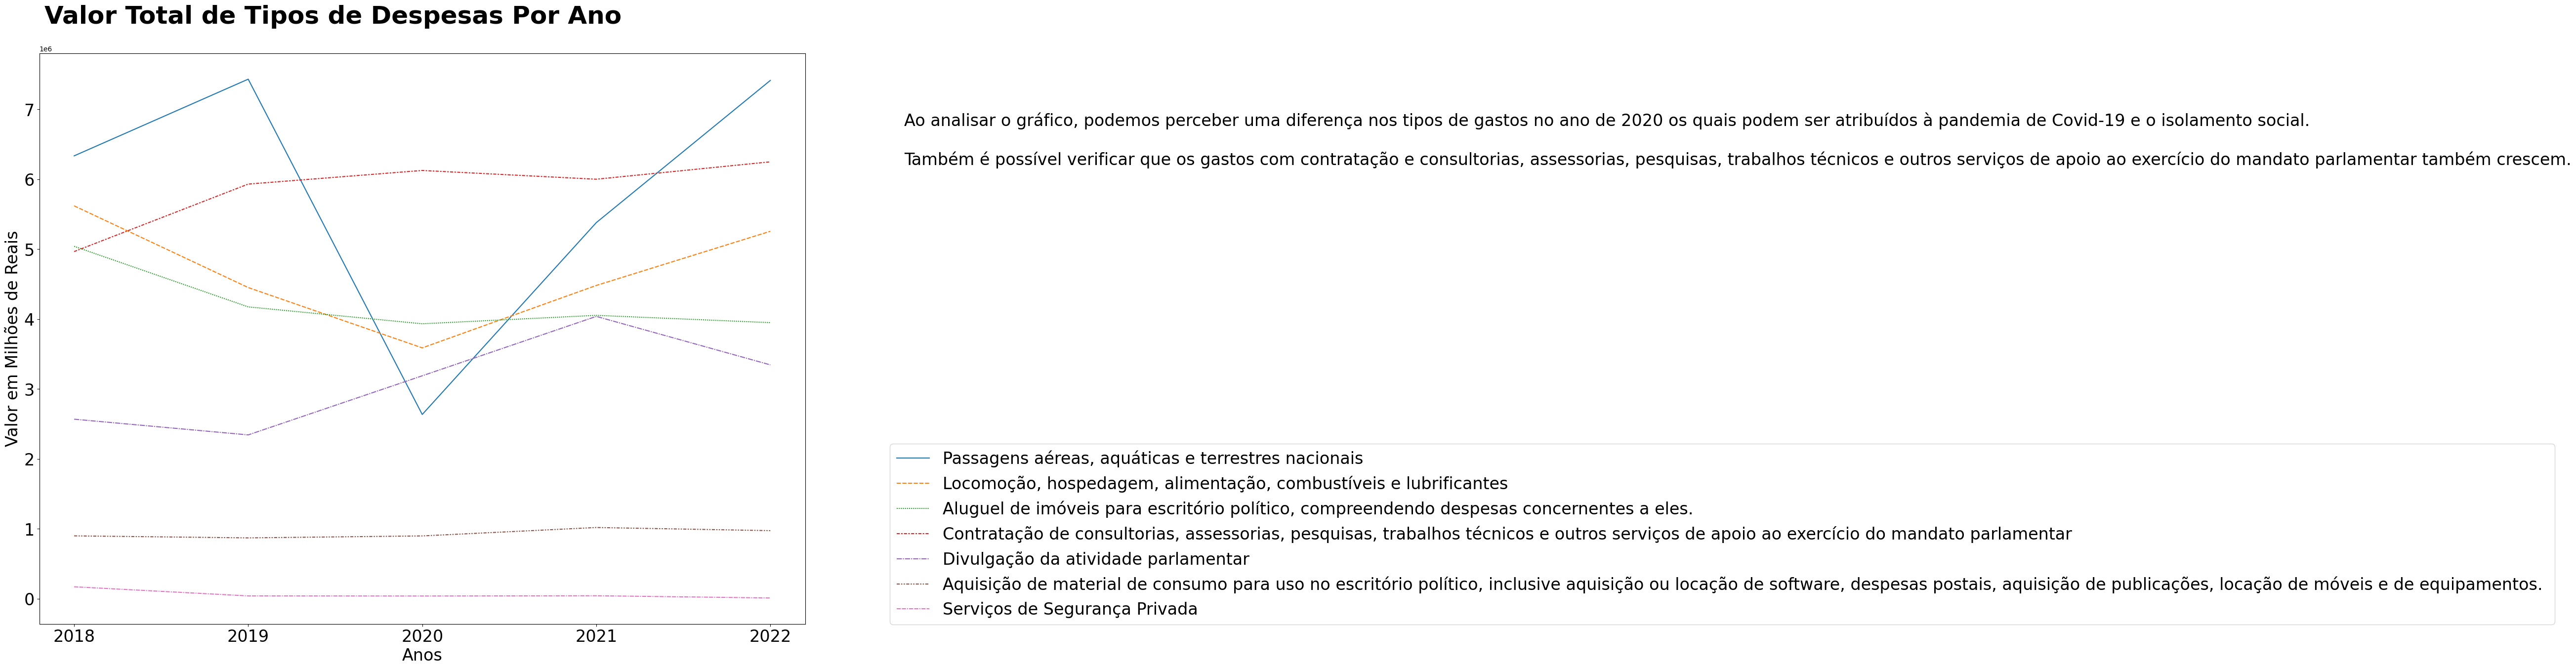

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

# Seu DataFrame
df = df_concat_type

# Criação do gráfico de linhas usando Seaborn
plt.figure(figsize=(20, 15))
sns.lineplot(data=df.T)

# Adicione rótulos e título com fontsize, fontweight e alinhamento à esquerda usando plt.text
plt.xlabel('Anos', fontsize=24)
plt.ylabel('Valor em Milhões de Reais', fontsize=24)

# Ajuste a posição da legenda
plt.legend(bbox_to_anchor=(1.1, 0.33), loc='upper left', fontsize=24)

# Adicione texto acima da legenda com quebra de linha usando bbox e boxstyle
fig = plt.gcf()  # Obtém o objeto de figura atual
texto = f'Ao analisar o gráfico, podemos perceber uma diferença nos tipos de gastos no ano de 2020 os quais podem ser atribuídos à pandemia de Covid-19 e o isolamento social.\n\nTambém é possível verificar que os gastos com contratação e consultorias, assessorias, pesquisas, trabalhos técnicos e outros serviços de apoio ao exercício do mandato parlamentar também crescem.'
fig.text(1, 0.8, texto, ha='left', va='top', fontsize=24, bbox={'boxstyle': 'square', 'facecolor': 'white', 'edgecolor': 'white', 'pad': 0.5}, wrap=True)

# Adicione o título manualmente com fontsize, fontweight e alinhamento à esquerda
plt.text(0.13, 0.92, 'Valor Total de Tipos de Despesas Por Ano', fontsize=36, fontweight='bold', ha='left', transform=fig.transFigure)

# Ajuste o tamanho da fonte do eixo x
plt.xticks(fontsize=24)

# Ajuste o tamanho da fonte do gráfico
plt.yticks(fontsize=24)

# Exiba o gráfico
plt.show()


## Armazenamento dos Dados
